In [22]:
!pip install scikeras

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time


import warnings
warnings.filterwarnings("ignore")

In [24]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [25]:
# Define a function to create CNN model
def create_model(nhid1=64, dropout_rate=0.2, learning_rate=0.001, weight_decay=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(nhid1, activation='relu', kernel_regularizer=l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [26]:
# Create KerasClassifier for scikit-learn compatibility
keras_model = KerasClassifier(model=create_model, nhid1=64, weight_decay=0.001, dropout_rate=0.2, epochs=15, batch_size=32, learning_rate=0.01, verbose=0)

# Define hyperparameters grid for GridSearchCV
param_grid = {
    'nhid1': [64, 128],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.01, 0.001]
}

# Define callbacks for model training
callbacks = [EarlyStopping(patience=1, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(factor=0.2, patience=1, verbose=1)]


In [27]:
start = time.time()

# Perform RandomizedSearchCV
rand_search = RandomizedSearchCV(estimator=keras_model, n_iter=10, param_distributions=param_grid,
                           cv=3, scoring='f1_macro', verbose=10, n_jobs=-1)
rand_result = rand_search.fit(X_train, y_train, callbacks=callbacks)

end = time.time()

# Print best hyperparameters and performance
print("------")
print(f"Best accuracy: {rand_result.best_score_}\nHyperParameters used: {rand_result.best_params_}\n")
print(f"Time employed: ~{(end-start)//60} minutes")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
------
Best accuracy: 0.9896335576997375
HyperParameters used: {'nhid1': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2}

Time employed: ~26.0 minutes


In [28]:
# Evaluate best model on test data
best_model = rand_search.best_estimator_
y_pred = best_model.predict(X_test)

y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [29]:
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Test Accuracy:", accuracy)
print("Test F1 (Macro):", f1_macro)

Test Accuracy: 0.9909
Test F1 (Macro): 0.9908027678256414


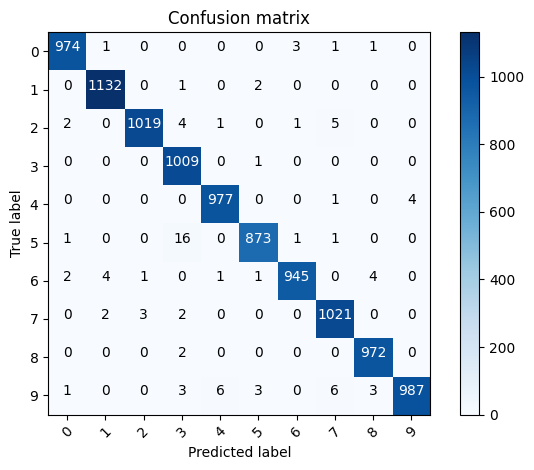

In [30]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), classes=range(10));